# SpotVariation-FCS analysis of time-tagging measurements

In [1]:
%pylab inline
import numpy as np
import pandas
import numpy as np
import pandas as pd
import math
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import copy
import os

C:\Users\eperego\AppData\Local\Programs\Python\Python310\lib\site-packages\libttp\ttp.py


In [ ]:
from spad_tools import *
from spad_fcs import *

In [2]:
from tqdm import tqdm
import libttp.ttp as ttp
ttp.__file__

'C:\\Users\\eperego\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\libttp\\ttp.py'

In [51]:
#Import your data - the data are provided in .h5 format
Path = #Your path
fname = "08_20nm_CrossCorr_APDSPAD_5050"
filename = Path+fname+".h5"

Opening the data

In [52]:
data_head, data_filename = os.path.split(filename)

In [53]:
sysclk_MHz=240.  # FPGA system clock (MHz)
laser_MHz= 80.    # Laser repetition rate (MHz)
nchannel = 26    # Number of active channels (25 for only SPAD 26 for cross correlation measurements)
kC4=43      

In [54]:
laser_Hz=laser_MHz*10**6
max_counter=2**16-1
sysclk_ps=1000000./sysclk_MHz #ps
print("SysClk ps:", sysclk_ps)
laser_ps=1000000./laser_MHz #ps
print("LaserClk ps:", laser_ps)
ratio=sysclk_MHz/laser_MHz
sysclk_ps=1e6/sysclk_MHz
laser_ps=1e6/laser_MHz
nbins=int(round(laser_ps/kC4))

SysClk ps: 4166.666666666667
LaserClk ps: 12500.0


In [55]:
fnameOut = filename

In [56]:
h_main=pd.read_hdf(fnameOut, key="main")

In [57]:
h_valid_L = h_main[h_main["valid_tdc_L"]==1]

In [58]:
CHANNELS = 27  # number of channels in your system 25 for only SPAD array measurement 27 for measurements with additional channles, e.g. single APD
data=loadATimesData(fnameOut, channels=CHANNELS)

  0%|                                                                                           | 0/27 [00:02<?, ?it/s]


ch_L calculated from ch_0


 93%|███████████████████████████████████████████████████████████████████████████▉      | 25/27 [00:55<00:04,  2.21s/it]

ch_25  not found probably no photons in this channel.


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:57<00:00,  2.14s/it]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26]
Loading channel 0
Loading channel 1
Loading channel 2
Loading channel 3
Loading channel 4
Loading channel 5
Loading channel 6
Loading channel 7
Loading channel 8
Loading channel 9
Loading channel 10
Loading channel 11
Loading channel 12
Loading channel 13
Loading channel 14
Loading channel 15
Loading channel 16
Loading channel 17
Loading channel 18
Loading channel 19
Loading channel 20
Loading channel 21
Loading channel 22
Loading channel 23
Loading channel 24
Loading channel 26


In [59]:
data.macrotime = 1e-12
data.microtime = 1e-12
print(data.microtime)

1e-12


Plot intensity time trace

Measurement duration: 118 s


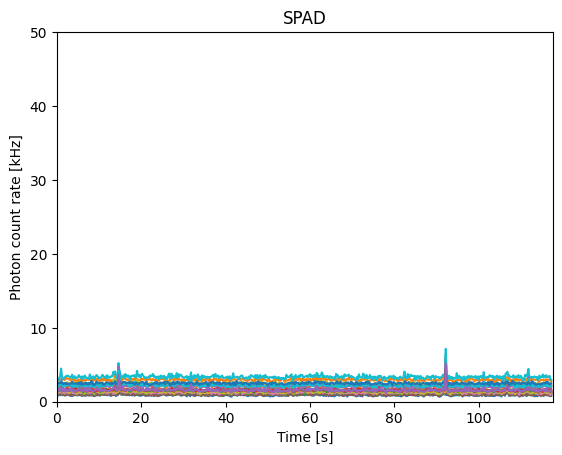

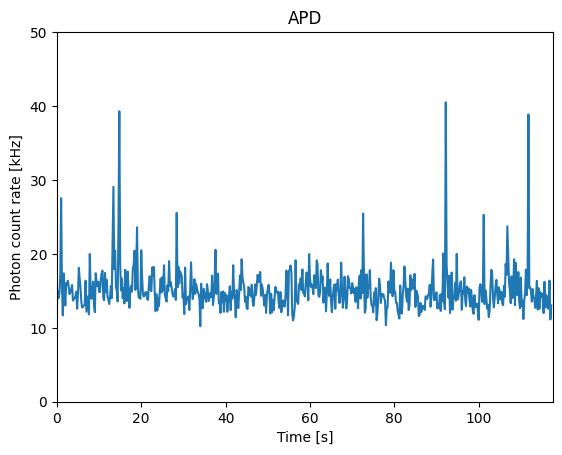

In [60]:
Ndet = 25 # number of channels
totTime = data.macrotime * (np.max(data.det12[:,0]))
print("Measurement duration: " + '{:.0f}'.format(totTime) + " s")

# plot the intensity trace for SPAD data
Lseg = 0.2
maxseg = int(np.floor(totTime / Lseg))

Nphotons = 0

leg = []
plt.figure()
for det in range(25):
    time = getattr(data, "det" + str(det))[:,0]
    Nphotons += np.shape(time)[0]
    timeAbs = time * data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
    plt.plot(timeBins[0:-2], Itrace[0:-1] / (timeBins[2] - timeBins[1]) / 1e3)
    leg.append('det ' + str(det))
plt.xlabel("Time [s]")
#plt.legend(leg)
plt.axis([0, totTime, 0, 50])
plt.title('SPAD')
output = plt.ylabel("Photon count rate [kHz]")


# plot the intensity trace for single APD data

plt.figure()
time = getattr(data, "det26")[:,0]
Nphotons += np.shape(time)[0]
timeAbs = time * data.macrotime
[Itrace, timeBins] = np.histogram(timeAbs, maxseg)
plt.plot(timeBins[0:-2], Itrace[0:-1] / (timeBins[2] - timeBins[1]) / 1e3)
plt.xlabel("Time [s]")
plt.axis([0, totTime, 0, 50])
plt.title('APD')
output = plt.ylabel("Photon count rate [kHz]")

In [61]:
# setting for plots
plt.rcParams.update({'font.size': 14})
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use("seaborn-colorblind")
lineW = 1

C:\Users\eperego\AppData\Local\Temp\ipykernel_13920\3252521361.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


Plotting the decay histograms 

Text(0.5, 1.0, 'Arrival times APD')

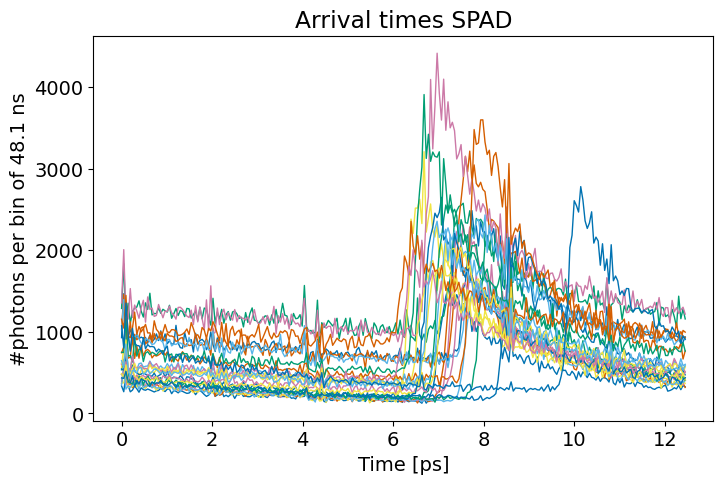

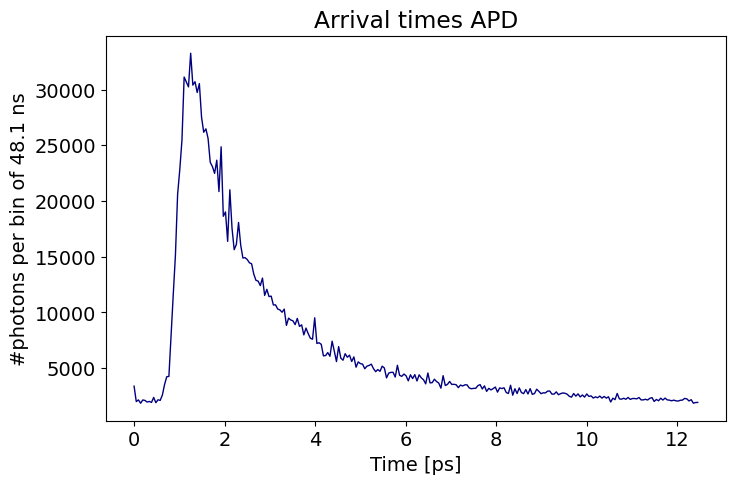

In [64]:

# Paramenters selection
laserF = 80e6 # laser frequency (Hz)
time_bin_width = 48 #ps

#Arrival time histogram for the SPAD data

MM = int(np.floor((10e11/laserF)/time_bin_width))
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
for det in range(Ndet):
    macroTime = getattr(data, "det" + str(det))[:,0] # ps
    microTime = getattr(data, "det" + str(det))[:,1]
    microTime = np.mod(microTime, 1e12 / laserF)
    microTime = -microTime + np.max(microTime)
    [Ihist, lifetimeBins] = np.histogram(microTime, MM)
    lifetimeBins = lifetimeBins[0:-1] * data.microtime * 1e12
    setattr(data, "hist" + str(det), np.transpose(np.stack((lifetimeBins, Ihist))))
    setattr(data, "det" + str(det), np.transpose([macroTime, microTime]))
    lifetimeBinsN = (lifetimeBins - lifetimeBins[0]) / lifetimeBins[1]
    plt.plot(1e-3*lifetimeBins, Ihist, linewidth=lineW)
    
data.microbintime = 1e-12 * lifetimeBins[1] # s
plt.xlabel("Time [ps]")
output = plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ns")
plt.title('Arrival times SPAD')


    
#Arrival time histogram for the single APD data
plt.figure(figsize=(8,5))    
macroTime = getattr(data, "det" + str(26))[:,0] # ps
microTime = getattr(data, "det" + str(26))[:,1]
microTime = np.mod(microTime, 1e12 / laserF)
microTime = -microTime + np.max(microTime)
[Ihist, lifetimeBins] = np.histogram(microTime, MM)
lifetimeBins = lifetimeBins[0:-1] * data.microtime * 1e12
setattr(data, "hist" + str(26), np.transpose(np.stack((lifetimeBins, Ihist))))
setattr(data, "det" + str(26), np.transpose([macroTime, microTime]))
lifetimeBinsN = (lifetimeBins - lifetimeBins[0]) / lifetimeBins[1]
plt.plot(1e-3*lifetimeBins, Ihist, linewidth=lineW, color = 'navy')

data.microbintime = 1e-12 * lifetimeBins[1] # s
plt.xlabel("Time [ps]")
output = plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ns")
plt.title('Arrival times APD')

In [65]:
#Aligning the histograms
data = alignLifetimeHist(data)

In [66]:
fontSize = 20
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
lineW = 1

C:\Users\eperego\AppData\Local\Temp\ipykernel_13920\3742576909.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


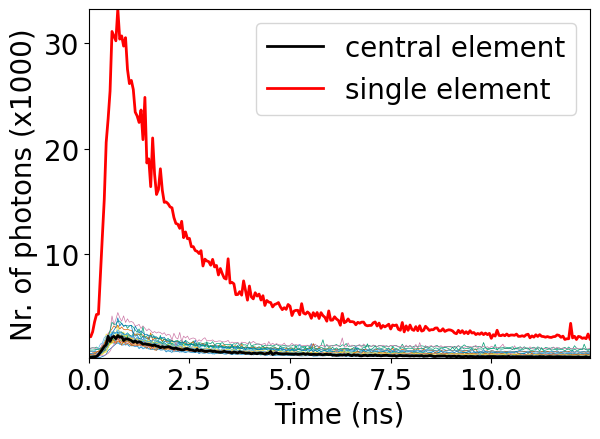

In [68]:
#Plotting the histograms, the central channel is pllotted in bold
plt.figure()
plt.margins(0,0)
for det in range(Ndet):
    histD = getattr(data, "Ahist" + str(det))
    if det != 12:
        plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=0.5)


histD = getattr(data, "Ahist" + str(12))
plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=lineW*2, color='black', label = 'central element')
histD = getattr(data, "Ahist" + str(26))
plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=lineW*2, color='red', label='single element')
    

plt.xlabel("Time (ns)")
#plt.axis([0, 25, 0, 3600])
output = plt.ylabel("Nr. of photons (x1000)") # of 43.4 ps
plt.tight_layout()
plt.legend()

Fitting the arrival time histogram to get the fluorescence lifetime value

In [70]:
# find index peak and zoom for the SPAD
Tmax = 150 
fitRange = np.zeros((Ndet, 2), dtype='int')
for det in range(Ndet):
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    idxStart = np.where(Ihist == np.max(Ihist))[0][0] + 1
    idxStop = np.where(Ihist[Tmax:] == np.min(Ihist[Tmax:]))[0][0] + Tmax + 1
    idxStop = np.minimum(idxStop, len(Ihist) - 1)
    fitRange[det, :] = [idxStart, idxStop]
    T = idxStop - idxStart
data.fitRange = fitRange

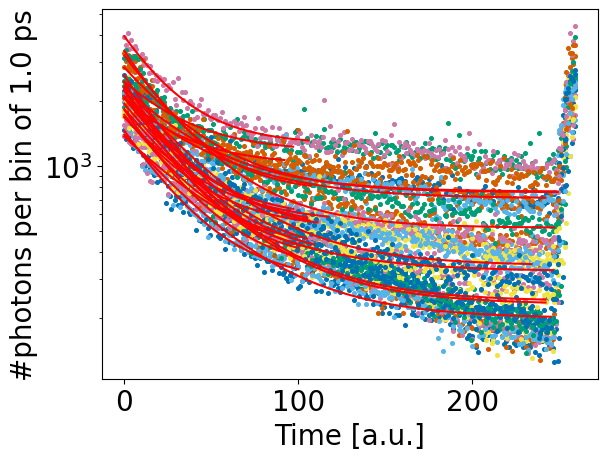

In [73]:
#Fitting the decay histograms with a single exponential model for every detector channel

fitresults = np.zeros((Ndet, 3))

plt.figure()
for det in range(Ndet):
    # get histogram detector element i
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    lifetimeBins = IhistSingle[:, 0]
    binTime = lifetimeBins[1]
    lifetimeBins /= binTime # bin numbers
    
    [idxStart, idxStop] = data.fitRange[det, :]
    fitRangeL = idxStop - idxStart
    
    Ihist = np.roll(Ihist, -idxStart)
    
    lifetimeBinsFit = (lifetimeBins[0:fitRangeL])
    IhistFit = Ihist[0:fitRangeL]
    
    plt.scatter(lifetimeBins, Ihist, s=7)
    plt.xlabel("Time [a.u.]")
    plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ps")

    # fit exponential
    
    fitresult = fitPowerLaw(IhistFit, lifetimeBinsFit, 'exp', [1, 1, 1], [60000, 4, 100], [0, 0, -1e4], [1e6, 20, 1e6])
    A      = fitresult.x[0]
    alpha  = fitresult.x[1]
    B      = fitresult.x[2]
    plt.plot(lifetimeBinsFit, A * np.exp(-alpha * lifetimeBinsFit) + B, color='r')
    plt.yscale('log')
    
    fitresults[det, :] = [A, alpha, B]

In [74]:
#Average fluorescene lifetime
print("lifetime = (" + '{:.2f}'.format(np.mean(1e9*data.microbintime/fitresults[:, 1])) + " +/- " + '{:.2f}'.format(np.std(1e9*data.microbintime/fitresults[:, 1])) + ") ns")

lifetime = (1.66 +/- 0.24) ns


In [80]:
# find index peak and zoom for the single APD 
Tmax = 10 
fitRange = np.zeros((1, 2), dtype='int')

IhistSingle = getattr(data, "hist" + str(26)) # number of photons per bin of 43.4 ps as a function of time in ps
Ihist = IhistSingle[:, 1]
idxStart = np.where(Ihist == np.max(Ihist))[0][0] + 1
idxStop = np.where(Ihist[Tmax:] == np.min(Ihist[Tmax:]))[0][0] + Tmax + 1
idxStop = np.minimum(idxStop, len(Ihist) - 1)
fitRange = [idxStart, idxStop]
T = idxStop - idxStart
data.fitRange = fitRange

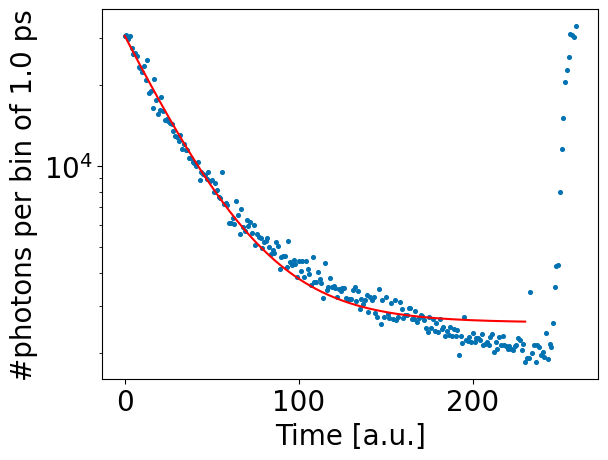

In [82]:
fitresults = np.zeros((1, 1))

plt.figure()
# get histogram detector element 26
IhistSingle = getattr(data, "hist" + str(26)) # number of photons per bin of 43.4 ps as a function of time in ps
Ihist = IhistSingle[:, 1]
lifetimeBins = IhistSingle[:, 0]
binTime = lifetimeBins[1]
lifetimeBins /= binTime # bin numbers

[idxStart, idxStop] = data.fitRange
fitRangeL = idxStop - idxStart

Ihist = np.roll(Ihist, -idxStart)

lifetimeBinsFit = (lifetimeBins[0:fitRangeL])
IhistFit = Ihist[0:fitRangeL]

plt.scatter(lifetimeBins, Ihist, s=7)
plt.xlabel("Time [a.u.]")
plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ps")
#plt.xlim([0, lifetimeBinsFit[-1]])

# fit exponential

fitresult = fitPowerLaw(IhistFit, lifetimeBinsFit, 'exp', [1, 1, 1], [60000, 4, 600], [0, 0, -1e4], [1e6, 20, 1e6])
A      = fitresult.x[0]
alpha  = fitresult.x[1]
B      = fitresult.x[2]
plt.plot(lifetimeBinsFit, A * np.exp(-alpha * lifetimeBinsFit) + B, color='r')
plt.yscale('log')

fitresults = [A, alpha, B]

In [83]:
#Average fluorescene lifetime SPAD
print("lifetime = " + '{:.2f}'.format(np.mean(1e9*data.microbintime/fitresults[1])) + " ns")

lifetime = 1.52 ns


### Calculating the Correlations

In [84]:
G = aTimes2CorrsParallel(data, listOfCorr = [12,"sum3","sum5",26, "cross"], accuracy=10, taumax=5/data.macrotime, split=5)
# it calculates the autocorrelation for the central element, for the sum of the inner 3x3 elements, for the sum of all 5x5 elements, for the single APD dataset 
# and the cross correlation between the sum3 and the APD data
# The time trace is splitted in chunks of 5 s each

Calculating correlation 12
   Filter 0
Calculating correlation sum3
Extracting and sorting photons
   Filter 0
Calculating correlation sum5
Extracting and sorting photons
   Filter 0
Calculating correlation 26
   Filter 0
Calculating correlation cross
Extracting photons channels APD and Sum3
   Filter 0


(-0.001, 0.19)

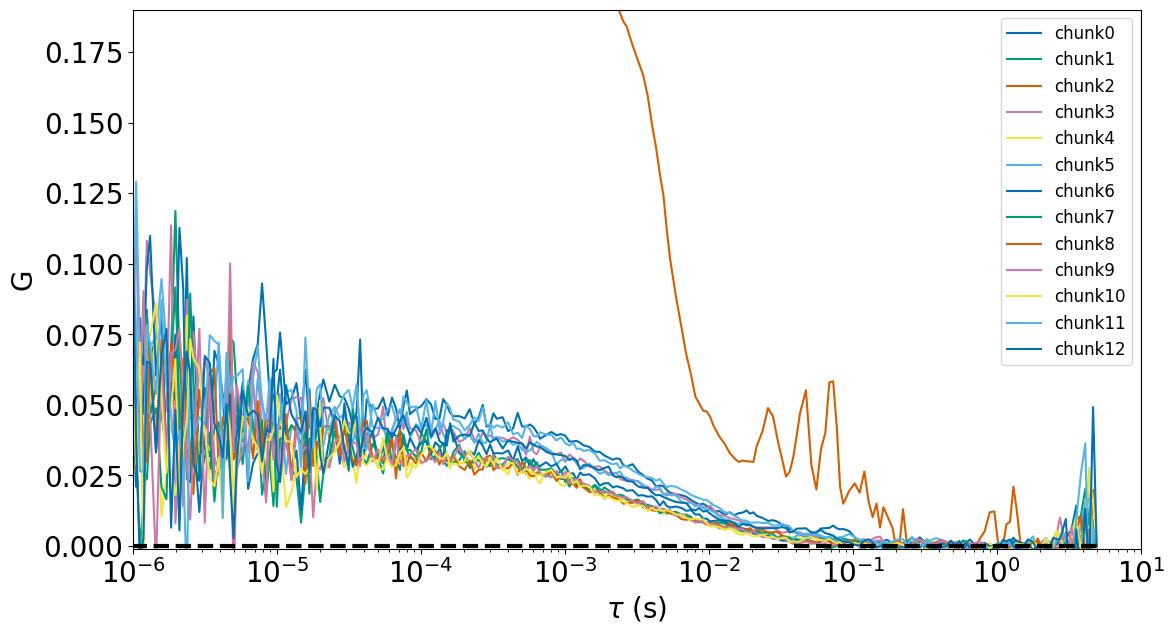

In [87]:
#Plotting every chunk for inspection

plt.figure(figsize=(13,7))
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk0[:,1], '-', label = 'chunk0')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk1[:,1], '-', label = 'chunk1')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk2[:,1], '-', label = 'chunk2')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk3[:,1], '-', label = 'chunk3')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk4[:,1], '-', label = 'chunk4')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk5[:,1], '-', label = 'chunk5')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk6[:,1], '-', label = 'chunk6')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk7[:,1], '-', label = 'chunk7')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk8[:,1], '-', label = 'chunk8')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk9[:,1], '-', label = 'chunk9')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk10[:,1], '-', label = 'chunk10')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk11[:,1], '-', label = 'chunk11')
plt.plot(G.sum5F0_average[:,0], G.sum5F0_chunk12[:,1], '-', label = 'chunk12')


plt.plot(G.sum5F0_average[:,0],np.zeros(len(G.sum5F0_average[:,0])), '--', color = 'black', lw = 3)

plt.xscale('log')
plt.xlabel(r'$\tau$ (s)')

plt.ylabel(r'G')
plt.legend(fontsize=12)
plt.xlim([1e-6, 10])
plt.ylim([-0.001, 0.19])

In [88]:
#Calculate the Average of the correlation curves
listOfChunks= [1,3,4,5,6,7,8,9,10,11,12]
G = FCSavChunks(G,listOfChunks)   ### averaging good chunks

## Fitting

------
1.9241453486080002
tauD = 50.13799617496173 ms
chi2 = 0.0074796408188897495
------
1.9241453486080002
tauD = 7.187713158410046 ms
chi2 = 0.0010968599061672451
------
1.9241453486080002
tauD = 1.4273066677987956 ms
chi2 = 0.0015068494620167933
tau_D = [50.13799617  7.18771316  1.42730667]ms
tau_D2 = [ 4.2098298  27.16702372  8.8130959 ]ms
%1 = [0.04424595 0.83194242 0.55269139]
N = [36.13914685 83.69112275 26.38892049]


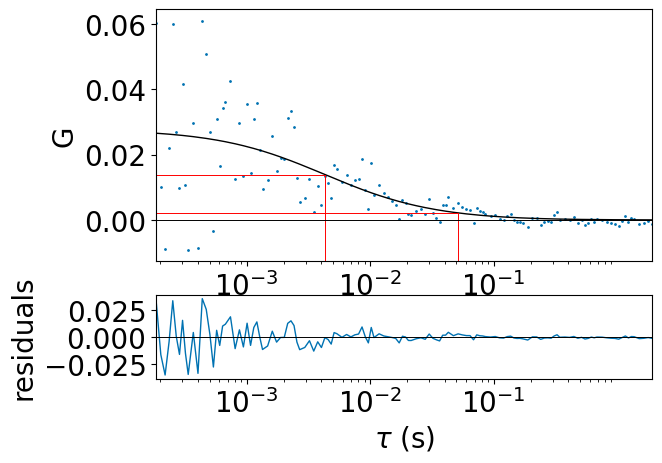

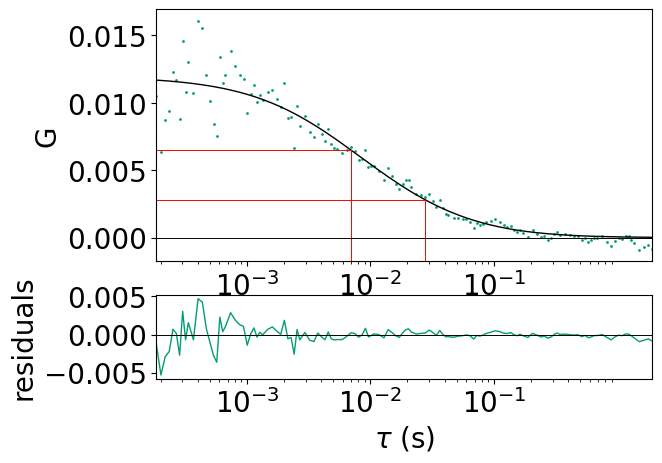

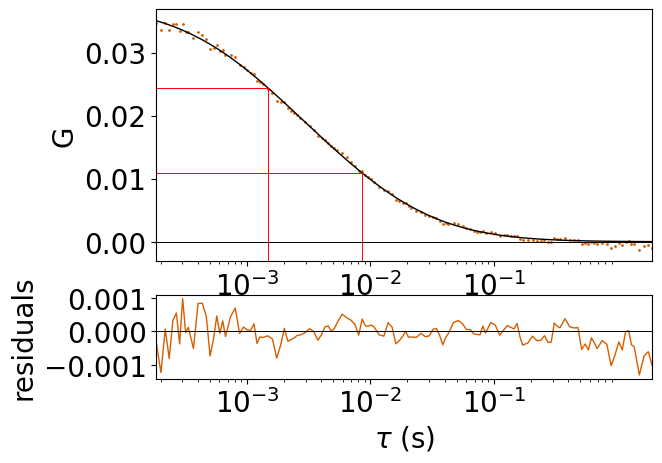

In [95]:
####----- Fitting the average with a 2 components fit -------------------

w0 = np.array([230e-9, 290e-9, 320e-9]) # Beam waist, based on the calibration of your setup
SF = np.array([4.5, 4.1, 4.1])

filters = 0
# order of fit parameters: [N, tauD1, tauD2, F, alpha, T, tautrip, SF, offset, A, B]
fitarray = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]) # parameters to fit
minBound = np.array([0, 5e-4, 5e-4, 0, 0, 0, 0, 0, 0, 0, 0]) # minimum values for the parameters
maxBound = np.array([1e6, 10000, 1e9, 1, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6]) # maximum values for the parameters

# # --------- central element ----------
det = 12
startValues = np.array([70, 1.5, 70, 0.6, 1, 0, 1e-6, SF[0], 0, 0, 1.05]) # start values for the fit
plotInfo = "C0" # used for the color of the output plot
Gsingle = getattr(G, 'det12F' + str(filters) + '_averageX')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
[dummy, start] = findNearest(tau, 180e-6)
[dummy, stop] = findNearest(tau, 2)

fitresult1 = FCSfit(Gexp[start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum3x3 ----------
startValues = np.array([70, 1.74, 70, 0.7, 1, 0, 1e-6, SF[1], 0, 0, 1.05]) # start values for the fit
plotInfo = "C1"
Gsingle = getattr(G, 'sum3F' + str(filters) + '_averageX')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
fitresult3 = FCSfit(Gexp[start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# # ---------- sum5x5 ----------
startValues = np.array([70, 2.04, 550, 0.7, 1, 0, 1e-6, SF[2], 0, 0, 1.05]) # start values for the fit
plotInfo = "C2"
Gsingle = getattr(G, 'sum5F' + str(filters) + '_averageX')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
fitresult5 = FCSfit(Gexp[start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)


tauD = 1e-3 * np.array([fitresult1.x[1], fitresult3.x[1], fitresult5.x[1]])
Dfit = w0**2 / 4 / ( tauD)

tauD2 = 1e-3 * np.array([fitresult1.x[2], fitresult3.x[2], fitresult5.x[2]])
Dfit2 = w0**2 / 4 / ( tauD2)

N =  np.array([fitresult1.x[0], fitresult3.x[0], fitresult5.x[0]])

print("tau_D = " + str(tauD*1.0e3) + "ms")
print("tau_D2 = " + str(tauD2*1.0e3) + "ms")

print("%1 = " + str(np.array([fitresult1.x[3], fitresult3.x[3], fitresult5.x[3]])))

print("N = " + str(N))

------
1.9241453486080002
tauD = 4.082800404044596 ms
chi2 = 0.00603688087569976
------
1.9241453486080002
tauD = 7.885236195155498 ms
chi2 = 0.0017568751641958708
tau_D = [4.0828004]ms
D =[7.9357296]um2/s
tau_D1 = [0.8947772 7.8852362]ms
D1 =[36.21013156  4.10894477]um2/s
Napd = 3.997653830340265
G0cross = 0.026561994317671457


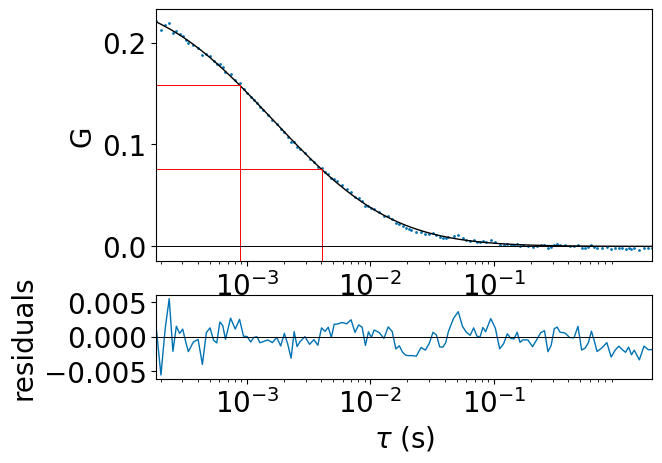

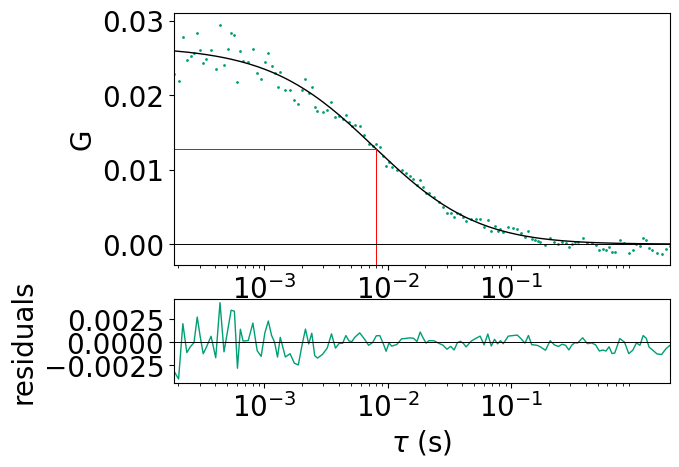

In [97]:
#####------------------------- Fitting APD and CrossCorrelation ----------------

w0 = np.array([360e-9]) # Beam waist, based on the calibration of your setup
SF = np.array([4.1])

filters = 0

fitarray = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]) # parameters to fit
minBound = np.array([0, 5e-4, 5e-4, 0, 0, 0, 0, 0, 0, 0, 0]) # minimum values for the parameters
maxBound = np.array([1e6, 2000, 1e9, 1, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6]) # maximum values for the parameters

# # ---------- APD ----------

det = 26
startValues = np.array([70, 150, 5, 1, 1, 0, 1e-6, SF[0], 0, 0, 1.05])  # start values for the fit
plotInfo = "C0" # used for the color of the output plot
Gsingle = getattr(G, 'det26F' + str(filters) + '_averageX')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
[dummy, start] = findNearest(tau, 180e-6)
[dummy, stop] = findNearest(tau, 2)

fitresult26 = FCSfit(Gexp[start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo,0, 0)

# ---------- CrossCorrelation ----------
fitarray = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # parameters to fit
minBound = np.array([0, 5e-8, 5e-8, 0, 0, 0, 0, 0, 0, 0, 0]) # minimum values for the parameters
maxBound = np.array([1e6, 2000, 1e9, 1, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6]) # maximum values for the parameters

startValues = np.array([70, 5, 5e-8, 1, 1, 0, 1e-6, SF[0], 0, 0, 1.05])  # start values for the fit
plotInfo = "C1"
Gsingle = getattr(G, 'crossF' + str(filters) + '_averageX')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
fitresultCross = FCSfit(Gexp[start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)


tauD1 = 1e-3 * np.array([fitresult26.x[2], fitresultCross.x[1]])
Dfit1 = w0**2 / 4 / ( tauD1)
tauD = 1e-3 * np.array([fitresult26.x[1]])
Dfit = w0**2 / 4 / ( tauD)

N =  np.array([fitresult26.x[0], fitresultCross.x[0]])

print("tau_D = " + str(tauD*1.0e3) + "ms")

print("tau_D1 = " + str(tauD1*1.0e3) + "ms")

print("Napd = " + str(N[0]))
print("G0cross = " + str( 1/fitresultCross.x[0]))